In [364]:
import numpy as np
import pandas as pd
import math
import codecs
import spacy
import json

import umap
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from PIL import Image, ImageDraw

import textacy
import textacy.tm
import textacy.preprocessing

from functools import partial

from pointgrid import align_points_to_grid


In [365]:
xlsx = pd.read_excel('abstracts.xlsx')
xlsx.rename(columns={'Title':'title', 'Abstract':'abstract'}, inplace=True); del xlsx['Notes']

authors = []; texts = []


for index, row in xlsx.iterrows():

    # Break on the last line

    if type(row['abstract']) != str:
        break


    # Authors

    _a = row['First name'] + ' ' + row['Last name']
    
    # if pd.notnull(row['Co1-Last']): _a += '; ' + row['Co1-First'] + ' ' + row['Co1-Last']
    # if pd.notnull(row['Co2-Last']): _a += '; ' + row['Co2-First'] + ' ' + row['Co2-Last']
    # if pd.notnull(row['Co3-Last']): _a += '; ' + row['Co3-First'] + ' ' + row['Co3-Last']
    # if pd.notnull(row['Co4-Last']): _a += '; ' + row['Co4-First'] + ' ' + row['Co4-Last']
    # if pd.notnull(row['Co5-Last']): _a += '; ' + row['Co5-First'] + ' ' + row['Co5-Last']
    # if pd.notnull(row['Co6-Last']): _a += '; ' + row['Co6-First'] + ' ' + row['Co6-Last']
    # if pd.notnull(row['Co7-Last']): _a += '; ' + row['Co7-First'] + ' ' + row['Co7-Last']


    # Keywords
    
    _k = ''

    if pd.notnull(row['keyword']): _k += row['keyword']
    if pd.notnull(row['keyword.1']): _k += ', ' + row['keyword.1']
    if pd.notnull(row['keyword.2']): _k += ', ' + row['keyword.2']
    if pd.notnull(row['keyword.3']): _k += ', ' + row['keyword.3']
    if pd.notnull(row['keyword.4']): _k += ', ' + row['keyword.4']


    # Text preprocessing

    _t = row['title'] + '. ' + row['abstract'] + ' ' + _k # Text

    
    
    # Remove references

    _t = _t.split('\nREFERENCE')[0]
    _t = _t.split('\nReference')[0]
    _t = _t.split('\nreference')[0]
    _t = _t.split(' References:')[0]
    _t = _t.split('References\n')[0]
    # _t = _t.replace('\n', ' ')
    # print(list(textacy.extract.keyword_in_context(_t, "reference", window_width=25, pad_context=True)))


    # Preprocessing

    preproc = textacy.preprocessing.make_pipeline(
        textacy.preprocessing.normalize.unicode,
        textacy.preprocessing.normalize.quotation_marks,
        textacy.preprocessing.normalize.whitespace,
        textacy.preprocessing.remove.brackets
    )
    
    _t = preproc(_t)


    # Save texts by author
    
    for a in _a.split("; "):
        if a in authors:
            index = authors.index(a)
            texts[index] = texts[index] + ' ' + _t
        else:
            authors.append(a)
            texts.append(_t)

len(texts)
# texts

290

In [366]:
# Parsing

en = textacy.load_spacy_lang("en_core_web_sm", disable=("parser",))
# en = textacy.load_spacy_lang("en_core_web_trf", disable=("parser",))

docs = []

for text in texts:
    doc = textacy.make_spacy_doc(text, lang=en)
    # doc = nlp(text)
    docs.append(doc)
    print(doc._.preview)

rew Feenberg and The Democratisation of Tech...")
Doc(282 tokens: "Technological Imaginaries: Christian Unmanned M...")
Doc(314 tokens: "The Digital Relation: a phenomenological analys...")
Doc(252 tokens: "Sociotechnical Imaginaries and the Art of Inter...")
Doc(115 tokens: "Technology and Ideology in the Thought of Herbe...")
Doc(340 tokens: "Revaluating instrumental value in environmental...")
Doc(698 tokens: "What is the value of digital utopianism?. Most ...")
Doc(456 tokens: "Civilisation Cultures and Technology. In its ev...")
Doc(183 tokens: "Technology and alternative futures. The core hy...")
Doc(300 tokens: "Negentropy for the Anthropocene; Stiegler, Maor...")
Doc(402 tokens: "Risk in Autonomous Warfare. One often discussed...")
Doc(150 tokens: "Beyond Romantic Sublime: expanding the percepti...")
Doc(290 tokens: "Information Theory as Engineering Knowledge: Fr...")
Doc(373 tokens: "Reimagining a Fairer Data Exchange in Smart Par...")
Doc(303 tokens: "The Future of AI: Stani

In [367]:
# Lematization

lemmas = []

ngs = partial(textacy.extract.ngrams, n=[1], include_pos={"NOUN"})
# ngs = partial(textacy.extract.ngrams, n=[1], include_pos={"NOUN"})
# ents = partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"})

for doc in docs:
    # extraction = textacy.extract.keyterms.textrank(doc, normalize='lemma')
    extraction = textacy.extract.terms(doc, ngs=ngs)
    # extraction = textacy.extract.basics.words(doc, filter_stops=True, filter_nums=True)
    lemmatization = textacy.extract.terms_to_strings(extraction, by="lemma")
    lemmas.append(list(lemmatization))

# TF-IDF

doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(lemmas, tf_type="linear", idf_type="smooth")

doc_term_matrix


<290x3158 sparse matrix of type '<class 'numpy.float64'>'
	with 14622 stored elements in Compressed Sparse Row format>

topic 0: technology  imaginary  philosophy
topic 1: engineering  reasoning  ethic
topic 2: value  health  energy
topic 3: design  model  vision
topic 4: robot  trust  interaction


<AxesSubplot:>

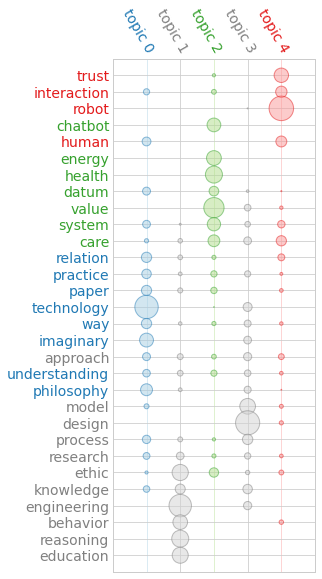

In [368]:
# import textacy
# from textacy.vsm import Vectorizer

model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

dictionary_inverted = {id: term for term, id in dictionary.items()}

import operator

topics = []

for doc in model.get_doc_topic_matrix(doc_term_matrix):
    index, value = max(enumerate(doc), key=operator.itemgetter(1))
    # print(index, doc)
    topics.append(index)

# for weight in model.topic_weights(doc_topic_matrix):
#     print(doc)
for topic_idx, terms in model.top_topic_terms(dictionary_inverted, top_n=3):
    print(f"topic {topic_idx}: {'  '.join(terms)}")
# for i, val in enumerate(model.topic_weights(doc_topic_matrix)):
#      print(i, val)

model.termite_plot(doc_term_matrix, dictionary_inverted, n_terms=30, highlight_topics=[0,2,4,6,8,10])

 * creating mesh with size 54 54
 * filling mesh


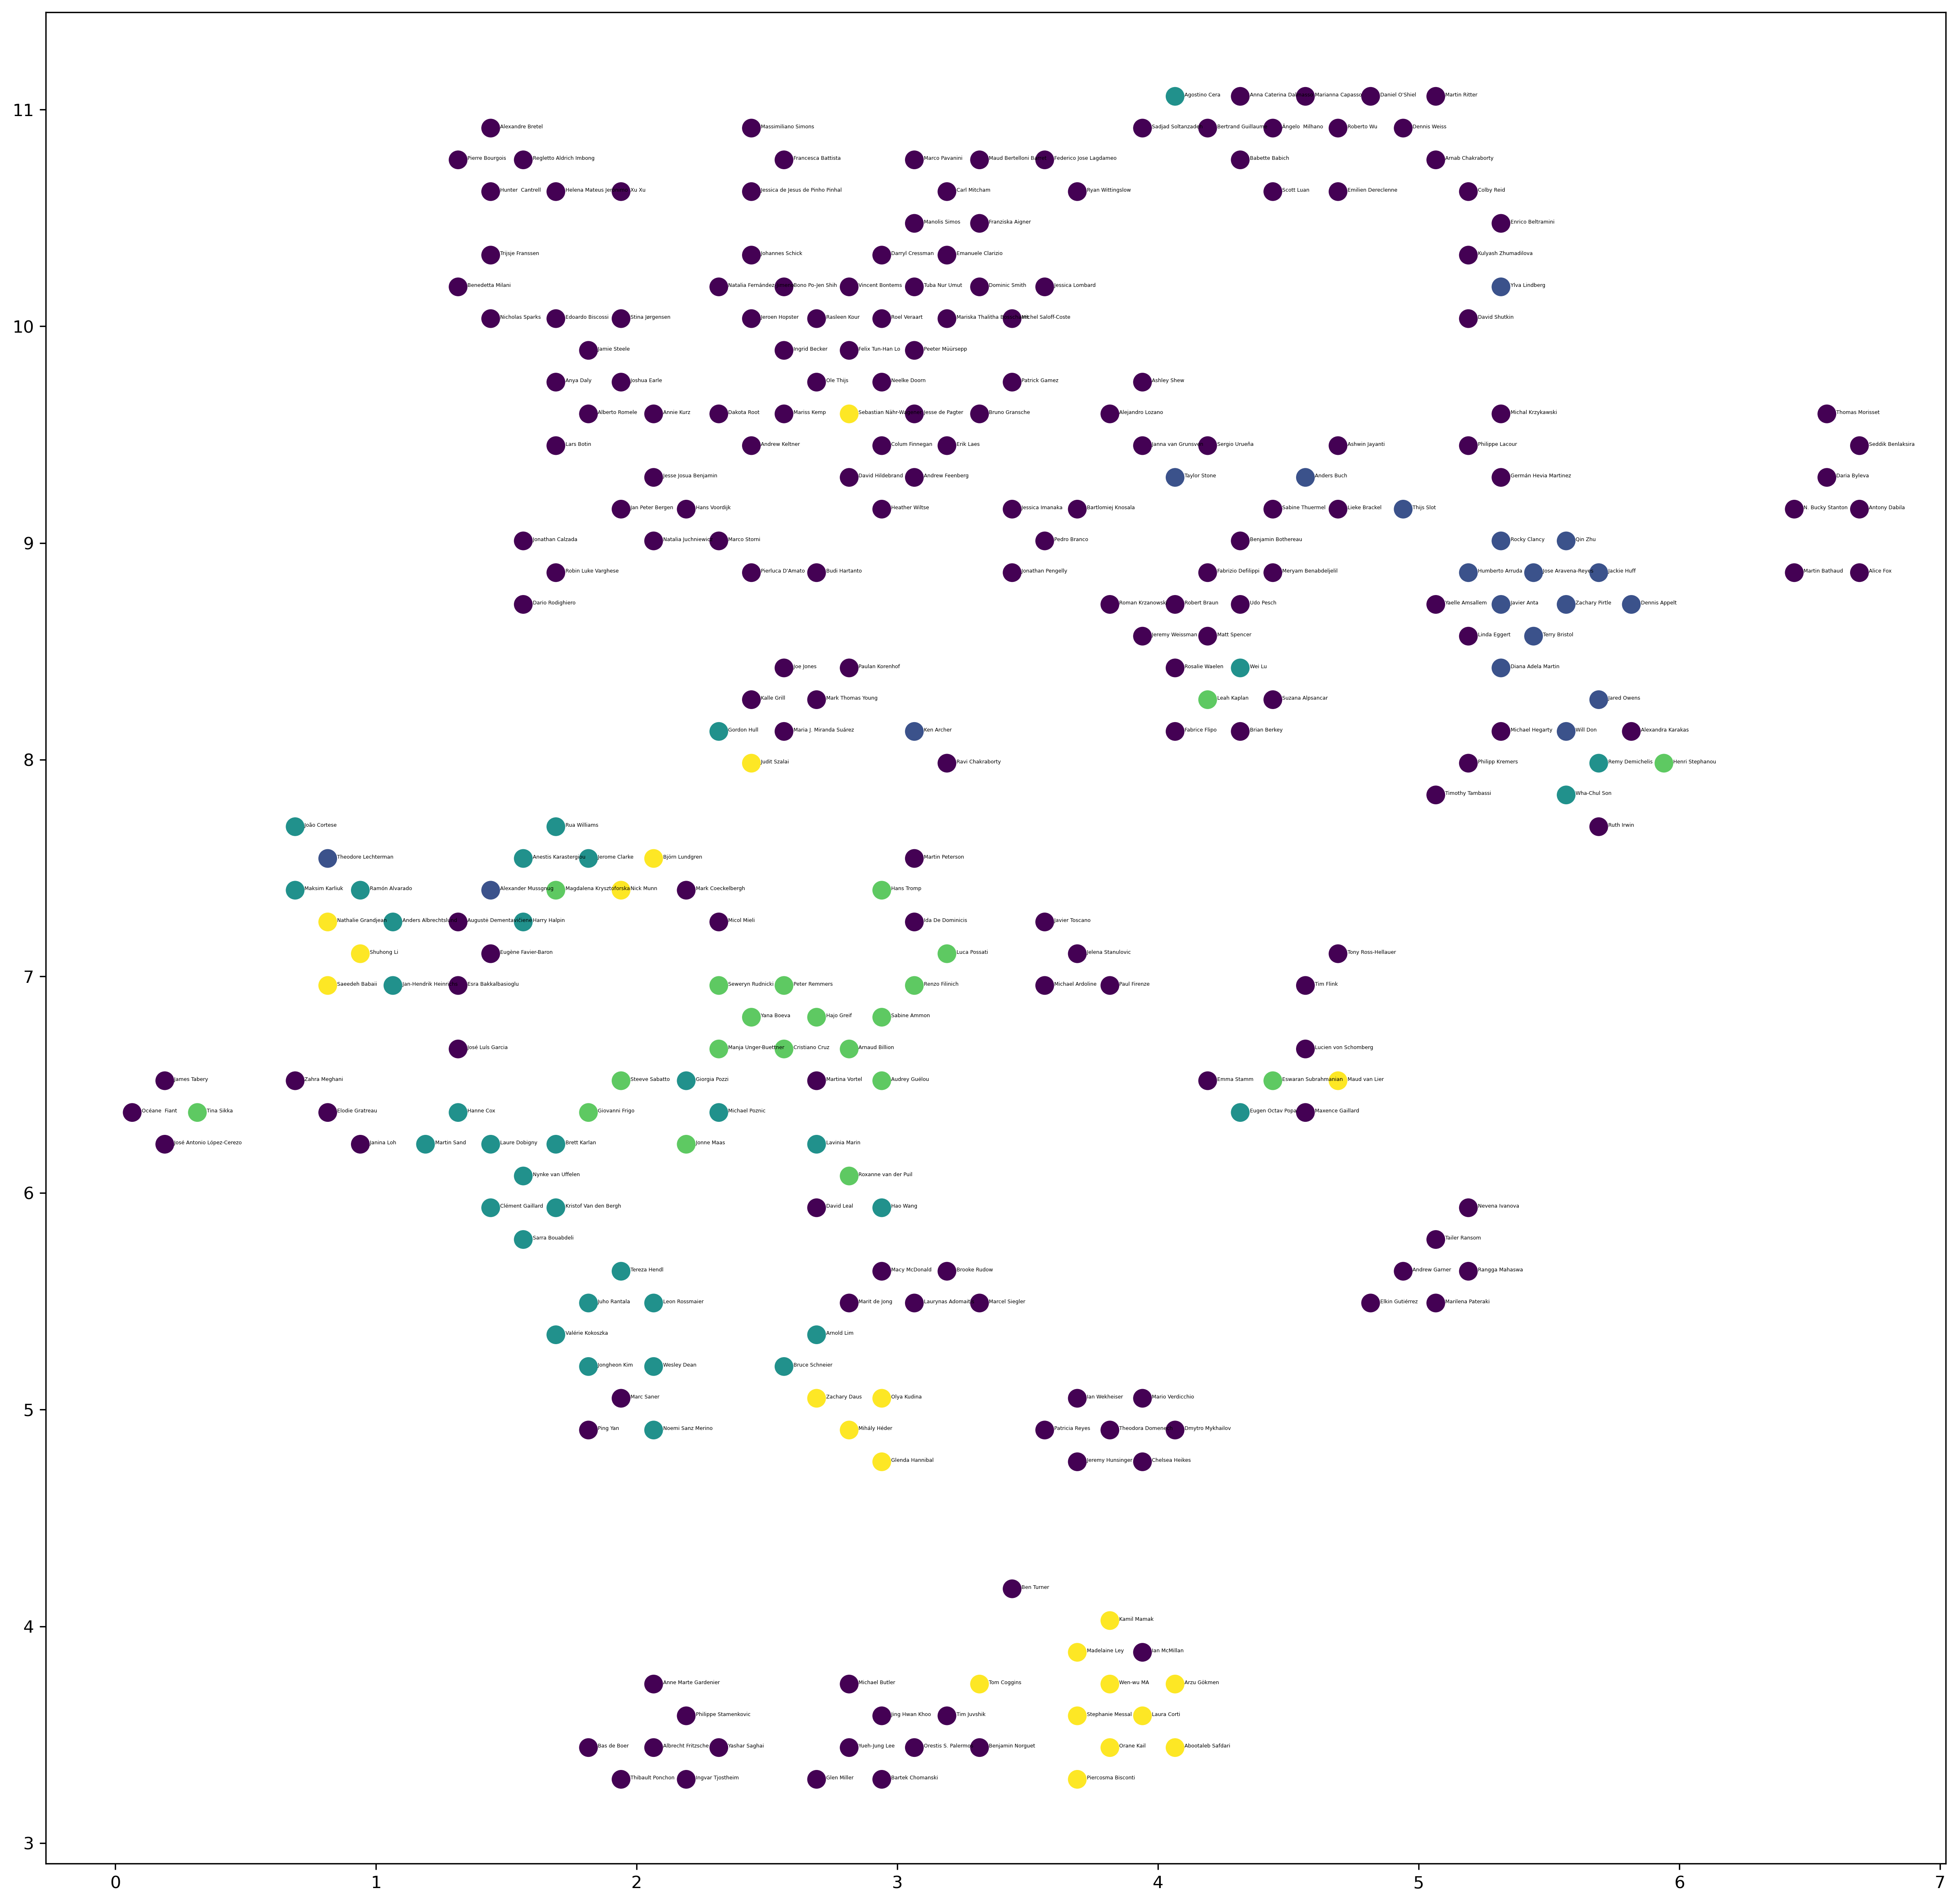

In [369]:
# UMAP

reducer = umap.UMAP(random_state=1, n_components=2, n_neighbors=5, min_dist=0.001, metric='cosine')

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

x = embedding[:, 0]; y = embedding[:, 1]

plt.figure(figsize=(20,20), dpi=300)
plt.scatter(x, y, s=100, c=topics)

for i, txt in enumerate(authors):
    text = plt.annotate(' ' + authors[i], (x[i] + .03, y[i]))
    text.set_fontsize(3)
    

In [370]:
pairs = []

for indexA, a in enumerate(embedding):
    for indexB, b in enumerate(embedding):
        distance = dist = math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)
        if 0 < distance and distance < .2:
            x = (b[0] + a[0]) / 2
            y = (b[1] + a[1]) / 2
            intersection = list(set(lemmas[indexA]) & set(lemmas[indexB]))
            pairs.append([x,y, intersection])
            # print('\n', x, y, intersection)
            # print()

print(len(pairs), 'lexical pairs')
pairs[0]


590 lexical pairs


[2.8774783611297607,
 4.832630157470703,
 ['research', 'people', 'trust', 'effort', 'approach']]

In [371]:
# Clustering on embedding

import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=3, cluster_selection_epsilon=0.4)
# clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon=0.3, cluster_selection_method='leaf')
# min_samples is to consier all the elements that owtherwide will be classified as noise
# cluster_selection_epsilon extends clusters
clusterer.fit(embedding)
clusters = clusterer.labels_

# Grouping by cluster

values = set(clusters)
values.remove(-1)
clusters = [[index for index, cluster in enumerate(clusters) if cluster==value] for value in values]

len(clusters)

13

In [466]:
# Word clouds for clusters

from planar import Polygon
from os import path


for index, cluster in enumerate(clusters):

    scale = 1000
    
    min_X = int(min([i[0] for i in embedding[cluster]]) * scale)
    max_X = int(max([i[0] for i in embedding[cluster]]) * scale)
    min_Y = int(min([i[1] for i in embedding[cluster]]) * scale)
    max_Y = int(max([i[1] for i in embedding[cluster]]) * scale)
    
    width = max_X - min_X; height = max_Y - min_Y
    points = list(map(lambda i: (int(i[0] * scale - min_X), int(i[1] * scale - min_Y)), embedding[cluster]))
    polygon = Polygon.convex_hull(points)
    points = list(map(lambda p: (int(p.x), int(p.y)), polygon))

    # Create mask

    img = Image.new(mode = "RGBA", size = (width, height), color = (255, 255, 255))
    draw = ImageDraw.Draw(img)
    draw.polygon(points, fill=(0,0,0))
    mask =np.array(img)
    # img.show()

    # Create word cloud

    text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'

    wc = WordCloud(mode = "RGBA", background_color=None, mask=mask, contour_width=0, scale=2)
    wc.generate(text) # generate word cloud
    wc.to_file(path.join("../src/data/wordclouds/" + str(index) + ".png")) # store to file




# clusterGroups = [None] * len(set(clusters))
# clusterCorpuses = [None] * len(set(clusters))

# for index, cluster in enumerate(clusters):
#     if (cluster == -1): continue
#     if (clusterGroups[cluster]):
#         clusterGroups[cluster].append(index)
#     else:
#         clusterGroups[cluster] = [index]

# corpus = textacy.Corpus(nlp, data=texts[:5])
# corpus[3]._.preview
# [doc._.preview for doc in corpus[0:2]]
# corpus.n_docs, corpus.n_sents, corpus.n_tokens

# clusterGroups

In [373]:
# Save files

json.dump(embedding.tolist(), codecs.open('../src/data/embedding.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(authors, codecs.open('../src/data/authors.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(lemmas, codecs.open('../src/data/lemmas.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(pairs, codecs.open('../src/data/pairs.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(topics, codecs.open('../src/data/topics.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)

json.dump(clusters, codecs.open('../src/data/clusters.json', 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=False, indent=4)